# Set up

In [124]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#!conda update conda -y

In [125]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [126]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 10 # values larger than 10 take considerably longer to complete
min_doc_size         =  4

## preprocessing settings
lower_chars          = True
strip_accents        = True
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.

## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"

## spell term と sound term の連結記号
pair_marker           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[3]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[3]
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_4gram
sn_term_type: sn_4gram


In [127]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 3 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [128]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
## HDP
use_HDP         = True
max_n_topics    = 45
n_terms_to_show = 120

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"

## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 45
n_topics for LDA: 45
top_perplexity_reduct_rate: 0.33


In [129]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [130]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[4]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: French () [lang_key: fr]
['data/open-dict-ipa/data1/fr_QC.csv.gz', 'data/open-dict-ipa/data1/fr_FR.csv.gz']


In [131]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,a,/a/
1,A,/a/
2,à,/a/
3,à aucun moment,/aokœ̃˞mɑɔ̯mæ̃/
4,à aucun prix,/aokœ̃˞pʁi/
...,...,...
245953,zyeutons,/zjøtõũ̯/
245954,zygomatique,/zɪgɑɔ̯mat͡sɪk/
245955,zygomatiques,/zɪgɑɔ̯mat͡sɪk/
245956,zygote,/zɪgɑɔ̯t/


In [132]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,a,a
1,a,a
2,à,a
3,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,à aucun prix,aokœ̃˞pʁi
...,...,...
245953,zyeutons,zjøtõũ̯
245954,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,zygote,zɪgɑɔ̯t


In [133]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,a,a
1,2,2,a,a
2,3,3,à,a
3,4,4,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,5,5,à aucun prix,aokœ̃˞pʁi
...,...,...,...,...
245953,245954,245954,zyeutons,zjøtõũ̯
245954,245955,245955,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,245956,245956,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,245957,245957,zygote,zɪgɑɔ̯t


In [134]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 7379 (0.030) rows by discarding 238579 rows


In [135]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [136]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

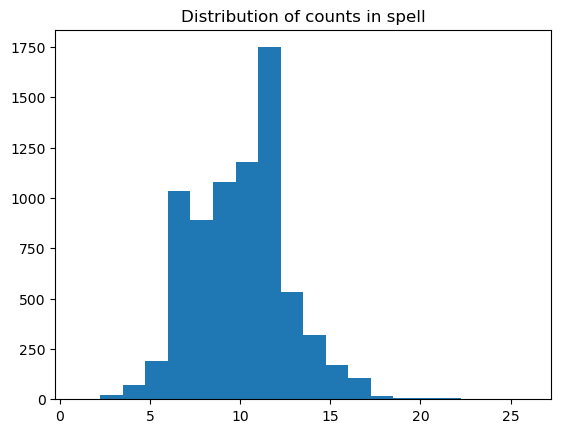

In [137]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

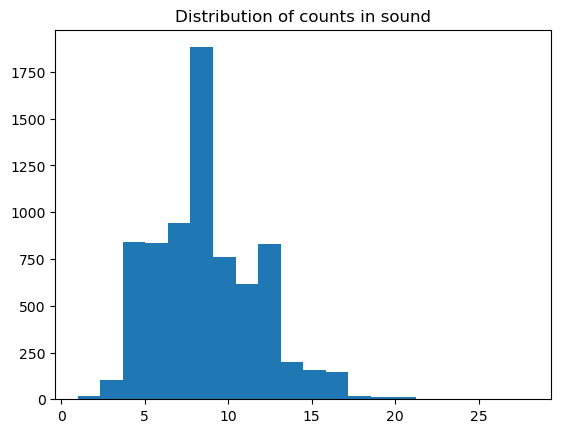

In [138]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [139]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 4 chars
discarding pairs whose sn_size part has more than 10 chars
2878 (0.390) pairs were removed
4501 pairs remain


In [140]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [141]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
22109,"[#, b, a, s, s, e, m, e, n, t, #]","[#, b, a, s, m, æ, ̃, #]"
163768,"[#, o, r, t, i, e, #]","[#, ɑ, ɔ, ̯, ʁ, t, ͡, s, i, #]"
77631,"[#, d, é, t, a, l, e, r, a, i, t, #]","[#, d, e, t, a, l, ə, ʁ, a, #]"
332,"[#, a, b, a, t, t, e, s, #]","[#, a, b, a, t, #]"
196052,"[#, r, e, f, l, e, u, r, i, r, a, s, #]","[#, ʁ, ə, f, l, œ, ʁ, ɪ, ʁ, ɔ, #]"
...,...,...
195204,"[#, r, e, d, o, u, t, a, i, t, #]","[#, ʁ, ə, d, ʊ, t, a, #]"
181227,"[#, p, r, é, s, e, n, t, a, #]","[#, p, ʁ, e, z, ɑ, ̃, t, ɔ, #]"
45611,"[#, c, o, m, m, u, n, i, a, i, #]","[#, k, ɑ, ɔ, ̯, m, ʏ, n, j, a, #]"
227062,"[#, s, u, s, p, e, c, t, a, i, t, #]","[#, s, ʏ, s, p, a, k, t, a, #]"


In [142]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 9002),
 ('e', 4704),
 ('a', 3953),
 ('s', 3951),
 ('r', 3351),
 ('i', 3284),
 ('t', 2646),
 ('n', 2497),
 ('u', 1630),
 ('o', 1608)]

In [143]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 9002),
 ('a', 3980),
 ('ʁ', 3114),
 ('e', 2153),
 ('s', 1699),
 ('t', 1446),
 ('ɪ', 1278),
 ('̯', 1156),
 ('l', 1144),
 ('ɑ', 1066)]

In [144]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [145]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [146]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [147]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [148]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#b, ba, as, ss, se, em, me, en, nt, t#, #, b,...
163768        [#o, or, rt, ti, ie, e#, #, o, r, t, i, e, #]
77631     [#d, dé, ét, ta, al, le, er, ra, ai, it, t#, #...
332       [#a, ab, ba, at, tt, te, es, s#, #, a, b, a, t...
196052    [#r, re, ef, fl, le, eu, ur, ri, ir, ra, as, s...
                                ...                        
195204    [#r, re, ed, do, ou, ut, ta, ai, it, t#, #, r,...
181227    [#p, pr, ré, és, se, en, nt, ta, a#, #, p, r, ...
45611     [#c, co, om, mm, mu, un, ni, ia, ai, i#, #, c,...
227062    [#s, su, us, sp, pe, ec, ct, ta, ai, it, t#, #...
142099        [#l, la, am, mp, pa, a#, #, l, a, m, p, a, #]
Name: sp_2gram, Length: 4501, dtype: object


In [149]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#ba, bas, ass, sse, sem, eme, men, ent, nt#, ...
163768    [#or, ort, rti, tie, ie#, #o, or, rt, ti, ie, e#]
77631     [#dé, dét, éta, tal, ale, ler, era, rai, ait, ...
332       [#ab, aba, bat, att, tte, tes, es#, #a, ab, ba...
196052    [#re, ref, efl, fle, leu, eur, uri, rir, ira, ...
                                ...                        
195204    [#re, red, edo, dou, out, uta, tai, ait, it#, ...
181227    [#pr, pré, rés, ése, sen, ent, nta, ta#, #p, p...
45611     [#co, com, omm, mmu, mun, uni, nia, iai, ai#, ...
227062    [#su, sus, usp, spe, pec, ect, cta, tai, ait, ...
142099    [#la, lam, amp, mpa, pa#, #l, la, am, mp, pa, a#]
Name: sp_3gram, Length: 4501, dtype: object


In [150]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#bas, bass, asse, ssem, seme, emen, ment, ent...
163768    [#ort, orti, rtie, tie#, #or, ort, rti, tie, ie#]
77631     [#dét, déta, étal, tale, aler, lera, erai, rai...
332       [#aba, abat, batt, atte, ttes, tes#, #ab, aba,...
196052    [#ref, refl, efle, fleu, leur, euri, urir, rir...
                                ...                        
195204    [#red, redo, edou, dout, outa, utai, tait, ait...
181227    [#pré, prés, rése, ésen, sent, enta, nta#, #pr...
45611     [#com, comm, ommu, mmun, muni, unia, niai, iai...
227062    [#sus, susp, uspe, spec, pect, ecta, ctai, tai...
142099    [#lam, lamp, ampa, mpa#, #la, lam, amp, mpa, pa#]
Name: sp_4gram, Length: 4501, dtype: object


In [151]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [152]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#b, #…a, #…s, #…s, ba, b…s, b…s, as, a…s, ss,...
163768    [#o, #…r, #…t, #…i, or, o…t, o…i, rt, r…i, ti,...
77631     [#d, #…é, #…t, #…a, dé, d…t, d…a, ét, é…a, ta,...
332       [#a, #…b, #…a, #…t, ab, a…a, a…t, ba, b…t, at,...
196052    [#r, #…e, #…f, #…l, re, r…f, r…l, ef, e…l, fl,...
                                ...                        
195204    [#r, #…e, #…d, #…o, re, r…d, r…o, ed, e…o, do,...
181227    [#p, #…r, #…é, #…s, pr, p…é, p…s, ré, r…s, és,...
45611     [#c, #…o, #…m, #…m, co, c…m, c…m, om, o…m, mm,...
227062    [#s, #…u, #…s, #…p, su, s…s, s…p, us, u…p, sp,...
142099    [#l, #…a, #…m, #…p, la, l…m, l…p, am, a…p, mp,...
Name: sp_sk2gram, Length: 4501, dtype: object


In [153]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#ba, #b…s, #b…s, #…as, #…a…s, #…ss, bas, ba…s...
163768    [#or, #o…t, #o…i, #…rt, #…r…i, #…ti, ort, or…i...
77631     [#dé, #d…t, #d…a, #…ét, #…é…a, #…ta, dét, dé…a...
332       [#ab, #a…a, #a…t, #…ba, #…b…t, #…at, aba, ab…t...
196052    [#re, #r…f, #r…l, #…ef, #…e…l, #…fl, ref, re…l...
                                ...                        
195204    [#re, #r…d, #r…o, #…ed, #…e…o, #…do, red, re…o...
181227    [#pr, #p…é, #p…s, #…ré, #…r…s, #…és, pré, pr…s...
45611     [#co, #c…m, #c…m, #…om, #…o…m, #…mm, com, co…m...
227062    [#su, #s…s, #s…p, #…us, #…u…p, #…sp, sus, su…p...
142099    [#la, #l…m, #l…p, #…am, #…a…p, #…mp, lam, la…p...
Name: sp_sk3gram, Length: 4501, dtype: object


In [154]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#bas, #ba…s, #b…ss, #…ass, bass, bass, bas…e,...
163768    [#ort, #or…i, #o…ti, #…rti, orti, orti, ort…e,...
77631     [#dét, #dé…a, #d…ta, #…éta, déta, déta, dét…l,...
332       [#aba, #ab…t, #a…at, #…bat, abat, abat, aba…t,...
196052    [#ref, #re…l, #r…fl, #…efl, refl, refl, ref…e,...
                                ...                        
195204    [#red, #re…o, #r…do, #…edo, redo, redo, red…u,...
181227    [#pré, #pr…s, #p…és, #…rés, prés, prés, pré…e,...
45611     [#com, #co…m, #c…mm, #…omm, comm, comm, com…u,...
227062    [#sus, #su…p, #s…sp, #…usp, susp, susp, sus…e,...
142099    [#lam, #la…p, #l…mp, #…amp, lamp, lamp, lam…a,...
Name: sp_sk4gram, Length: 4501, dtype: object


In [155]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [156]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram
22109,#bassement#,"[#b, #…a, #…s, #…s, ba, b…s, b…s, as, a…s, ss,...","[#ba, #b…s, #b…s, #…as, #…a…s, #…ss, bas, ba…s...","[#bas, #ba…s, #b…ss, #…ass, bass, bass, bas…e,..."
163768,#ortie#,"[#o, #…r, #…t, #…i, or, o…t, o…i, rt, r…i, ti,...","[#or, #o…t, #o…i, #…rt, #…r…i, #…ti, ort, or…i...","[#ort, #or…i, #o…ti, #…rti, orti, orti, ort…e,..."
77631,#détalerait#,"[#d, #…é, #…t, #…a, dé, d…t, d…a, ét, é…a, ta,...","[#dé, #d…t, #d…a, #…ét, #…é…a, #…ta, dét, dé…a...","[#dét, #dé…a, #d…ta, #…éta, déta, déta, dét…l,..."
332,#abattes#,"[#a, #…b, #…a, #…t, ab, a…a, a…t, ba, b…t, at,...","[#ab, #a…a, #a…t, #…ba, #…b…t, #…at, aba, ab…t...","[#aba, #ab…t, #a…at, #…bat, abat, abat, aba…t,..."
196052,#refleuriras#,"[#r, #…e, #…f, #…l, re, r…f, r…l, ef, e…l, fl,...","[#re, #r…f, #r…l, #…ef, #…e…l, #…fl, ref, re…l...","[#ref, #re…l, #r…fl, #…efl, refl, refl, ref…e,..."
...,...,...,...,...
195204,#redoutait#,"[#r, #…e, #…d, #…o, re, r…d, r…o, ed, e…o, do,...","[#re, #r…d, #r…o, #…ed, #…e…o, #…do, red, re…o...","[#red, #re…o, #r…do, #…edo, redo, redo, red…u,..."
181227,#présenta#,"[#p, #…r, #…é, #…s, pr, p…é, p…s, ré, r…s, és,...","[#pr, #p…é, #p…s, #…ré, #…r…s, #…és, pré, pr…s...","[#pré, #pr…s, #p…és, #…rés, prés, prés, pré…e,..."
45611,#communiai#,"[#c, #…o, #…m, #…m, co, c…m, c…m, om, o…m, mm,...","[#co, #c…m, #c…m, #…om, #…o…m, #…mm, com, co…m...","[#com, #co…m, #c…mm, #…omm, comm, comm, com…u,..."
227062,#suspectait#,"[#s, #…u, #…s, #…p, su, s…s, s…p, us, u…p, sp,...","[#su, #s…s, #s…p, #…us, #…u…p, #…sp, sus, su…p...","[#sus, #su…p, #s…sp, #…usp, susp, susp, sus…e,..."


# Sound n-grams 生成

In [157]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#b, ba, as, sm, mæ, æ̃, ̃#, #, b, a, s, m, æ,...
163768    [#ɑ, ɑɔ, ɔ̯, ̯ʁ, ʁt, t͡, ͡s, si, i#, #, ɑ, ɔ, ...
77631     [#d, de, et, ta, al, lə, əʁ, ʁa, a#, #, d, e, ...
332                  [#a, ab, ba, at, t#, #, a, b, a, t, #]
196052    [#ʁ, ʁə, əf, fl, lœ, œʁ, ʁɪ, ɪʁ, ʁɔ, ɔ#, #, ʁ,...
                                ...                        
195204    [#ʁ, ʁə, əd, dʊ, ʊt, ta, a#, #, ʁ, ə, d, ʊ, t,...
181227    [#p, pʁ, ʁe, ez, zɑ, ɑ̃, ̃t, tɔ, ɔ#, #, p, ʁ, ...
45611     [#k, kɑ, ɑɔ, ɔ̯, ̯m, mʏ, ʏn, nj, ja, a#, #, k,...
227062    [#s, sʏ, ʏs, sp, pa, ak, kt, ta, a#, #, s, ʏ, ...
142099        [#l, lɑ, ɑ̃, ̃p, pɔ, ɔ#, #, l, ɑ, ̃, p, ɔ, #]
Name: sn_2gram, Length: 4501, dtype: object


In [158]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#ba, bas, asm, smæ, mæ̃, æ̃#, #b, ba, as, sm,...
163768    [#ɑɔ, ɑɔ̯, ɔ̯ʁ, ̯ʁt, ʁt͡, t͡s, ͡si, si#, #ɑ, ɑ...
77631     [#de, det, eta, tal, alə, ləʁ, əʁa, ʁa#, #d, d...
332                [#ab, aba, bat, at#, #a, ab, ba, at, t#]
196052    [#ʁə, ʁəf, əfl, flœ, lœʁ, œʁɪ, ʁɪʁ, ɪʁɔ, ʁɔ#, ...
                                ...                        
195204    [#ʁə, ʁəd, ədʊ, dʊt, ʊta, ta#, #ʁ, ʁə, əd, dʊ,...
181227    [#pʁ, pʁe, ʁez, ezɑ, zɑ̃, ɑ̃t, ̃tɔ, tɔ#, #p, p...
45611     [#kɑ, kɑɔ, ɑɔ̯, ɔ̯m, ̯mʏ, mʏn, ʏnj, nja, ja#, ...
227062    [#sʏ, sʏs, ʏsp, spa, pak, akt, kta, ta#, #s, s...
142099    [#lɑ, lɑ̃, ɑ̃p, ̃pɔ, pɔ#, #l, lɑ, ɑ̃, ̃p, pɔ, ɔ#]
Name: sn_3gram, Length: 4501, dtype: object


In [159]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#bas, basm, asmæ, smæ̃, mæ̃#, #ba, bas, asm, ...
163768    [#ɑɔ̯, ɑɔ̯ʁ, ɔ̯ʁt, ̯ʁt͡, ʁt͡s, t͡si, ͡si#, #ɑɔ...
77631     [#det, deta, etal, talə, aləʁ, ləʁa, əʁa#, #de...
332                  [#aba, abat, bat#, #ab, aba, bat, at#]
196052    [#ʁəf, ʁəfl, əflœ, flœʁ, lœʁɪ, œʁɪʁ, ʁɪʁɔ, ɪʁɔ...
                                ...                        
195204    [#ʁəd, ʁədʊ, ədʊt, dʊta, ʊta#, #ʁə, ʁəd, ədʊ, ...
181227    [#pʁe, pʁez, ʁezɑ, ezɑ̃, zɑ̃t, ɑ̃tɔ, ̃tɔ#, #pʁ...
45611     [#kɑɔ, kɑɔ̯, ɑɔ̯m, ɔ̯mʏ, ̯mʏn, mʏnj, ʏnja, nja...
227062    [#sʏs, sʏsp, ʏspa, spak, pakt, akta, kta#, #sʏ...
142099    [#lɑ̃, lɑ̃p, ɑ̃pɔ, ̃pɔ#, #lɑ, lɑ̃, ɑ̃p, ̃pɔ, pɔ#]
Name: sn_4gram, Length: 4501, dtype: object


In [160]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [161]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#b, #…a, #…s, #…m, ba, b…s, b…m, as, a…m, sm,...
163768    [#ɑ, #…ɔ, #…̯, #…ʁ, ɑɔ, ɑ…̯, ɑ…ʁ, ɔ̯, ɔ…ʁ, ̯ʁ,...
77631     [#d, #…e, #…t, #…a, de, d…t, d…a, et, e…a, ta,...
332       [#a, #…b, #…a, #…t, ab, a…a, a…t, ba, b…t, at,...
196052    [#ʁ, #…ə, #…f, #…l, ʁə, ʁ…f, ʁ…l, əf, ə…l, fl,...
                                ...                        
195204    [#ʁ, #…ə, #…d, #…ʊ, ʁə, ʁ…d, ʁ…ʊ, əd, ə…ʊ, dʊ,...
181227    [#p, #…ʁ, #…e, #…z, pʁ, p…e, p…z, ʁe, ʁ…z, ez,...
45611     [#k, #…ɑ, #…ɔ, #…̯, kɑ, k…ɔ, k…̯, ɑɔ, ɑ…̯, ɔ̯,...
227062    [#s, #…ʏ, #…s, #…p, sʏ, s…s, s…p, ʏs, ʏ…p, sp,...
142099    [#l, #…ɑ, #…̃, #…p, lɑ, l…̃, l…p, ɑ̃, ɑ…p, ̃p,...
Name: sn_sk2gram, Length: 4501, dtype: object


In [162]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#ba, #b…s, #b…m, #…as, #…a…m, #…sm, bas, ba…m...
163768    [#ɑɔ, #ɑ…̯, #ɑ…ʁ, #…ɔ̯, #…ɔ…ʁ, #…̯ʁ, ɑɔ̯, ɑɔ…ʁ...
77631     [#de, #d…t, #d…a, #…et, #…e…a, #…ta, det, de…a...
332       [#ab, #a…a, #a…t, #…ba, #…b…t, #…at, aba, ab…t...
196052    [#ʁə, #ʁ…f, #ʁ…l, #…əf, #…ə…l, #…fl, ʁəf, ʁə…l...
                                ...                        
195204    [#ʁə, #ʁ…d, #ʁ…ʊ, #…əd, #…ə…ʊ, #…dʊ, ʁəd, ʁə…ʊ...
181227    [#pʁ, #p…e, #p…z, #…ʁe, #…ʁ…z, #…ez, pʁe, pʁ…z...
45611     [#kɑ, #k…ɔ, #k…̯, #…ɑɔ, #…ɑ…̯, #…ɔ̯, kɑɔ, kɑ…̯...
227062    [#sʏ, #s…s, #s…p, #…ʏs, #…ʏ…p, #…sp, sʏs, sʏ…p...
142099    [#lɑ, #l…̃, #l…p, #…ɑ̃, #…ɑ…p, #…̃p, lɑ̃, lɑ…p...
Name: sn_sk3gram, Length: 4501, dtype: object


In [163]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

22109     [#bas, #ba…m, #b…sm, #…asm, basm, basm, bas…æ,...
163768    [#ɑɔ̯, #ɑɔ…ʁ, #ɑ…̯ʁ, #…ɔ̯ʁ, ɑɔ̯ʁ, ɑɔ̯ʁ, ɑɔ̯…t,...
77631     [#det, #de…a, #d…ta, #…eta, deta, deta, det…l,...
332       [#aba, #ab…t, #a…at, #…bat, abat, abat, aba…#,...
196052    [#ʁəf, #ʁə…l, #ʁ…fl, #…əfl, ʁəfl, ʁəfl, ʁəf…œ,...
                                ...                        
195204    [#ʁəd, #ʁə…ʊ, #ʁ…dʊ, #…ədʊ, ʁədʊ, ʁədʊ, ʁəd…t,...
181227    [#pʁe, #pʁ…z, #p…ez, #…ʁez, pʁez, pʁez, pʁe…ɑ,...
45611     [#kɑɔ, #kɑ…̯, #k…ɔ̯, #…ɑɔ̯, kɑɔ̯, kɑɔ̯, kɑɔ…m,...
227062    [#sʏs, #sʏ…p, #s…sp, #…ʏsp, sʏsp, sʏsp, sʏs…a,...
142099    [#lɑ̃, #lɑ…p, #l…̃p, #…ɑ̃p, lɑ̃p, lɑ̃p, lɑ̃…ɔ,...
Name: sn_sk4gram, Length: 4501, dtype: object


In [164]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [165]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram
22109,#basmæ̃#,"[#b, #…a, #…s, #…m, ba, b…s, b…m, as, a…m, sm,...","[#ba, #b…s, #b…m, #…as, #…a…m, #…sm, bas, ba…m...","[#bas, #ba…m, #b…sm, #…asm, basm, basm, bas…æ,..."
163768,#ɑɔ̯ʁt͡si#,"[#ɑ, #…ɔ, #…̯, #…ʁ, ɑɔ, ɑ…̯, ɑ…ʁ, ɔ̯, ɔ…ʁ, ̯ʁ,...","[#ɑɔ, #ɑ…̯, #ɑ…ʁ, #…ɔ̯, #…ɔ…ʁ, #…̯ʁ, ɑɔ̯, ɑɔ…ʁ...","[#ɑɔ̯, #ɑɔ…ʁ, #ɑ…̯ʁ, #…ɔ̯ʁ, ɑɔ̯ʁ, ɑɔ̯ʁ, ɑɔ̯…t,..."
77631,#detaləʁa#,"[#d, #…e, #…t, #…a, de, d…t, d…a, et, e…a, ta,...","[#de, #d…t, #d…a, #…et, #…e…a, #…ta, det, de…a...","[#det, #de…a, #d…ta, #…eta, deta, deta, det…l,..."
332,#abat#,"[#a, #…b, #…a, #…t, ab, a…a, a…t, ba, b…t, at,...","[#ab, #a…a, #a…t, #…ba, #…b…t, #…at, aba, ab…t...","[#aba, #ab…t, #a…at, #…bat, abat, abat, aba…#,..."
196052,#ʁəflœʁɪʁɔ#,"[#ʁ, #…ə, #…f, #…l, ʁə, ʁ…f, ʁ…l, əf, ə…l, fl,...","[#ʁə, #ʁ…f, #ʁ…l, #…əf, #…ə…l, #…fl, ʁəf, ʁə…l...","[#ʁəf, #ʁə…l, #ʁ…fl, #…əfl, ʁəfl, ʁəfl, ʁəf…œ,..."
...,...,...,...,...
195204,#ʁədʊta#,"[#ʁ, #…ə, #…d, #…ʊ, ʁə, ʁ…d, ʁ…ʊ, əd, ə…ʊ, dʊ,...","[#ʁə, #ʁ…d, #ʁ…ʊ, #…əd, #…ə…ʊ, #…dʊ, ʁəd, ʁə…ʊ...","[#ʁəd, #ʁə…ʊ, #ʁ…dʊ, #…ədʊ, ʁədʊ, ʁədʊ, ʁəd…t,..."
181227,#pʁezɑ̃tɔ#,"[#p, #…ʁ, #…e, #…z, pʁ, p…e, p…z, ʁe, ʁ…z, ez,...","[#pʁ, #p…e, #p…z, #…ʁe, #…ʁ…z, #…ez, pʁe, pʁ…z...","[#pʁe, #pʁ…z, #p…ez, #…ʁez, pʁez, pʁez, pʁe…ɑ,..."
45611,#kɑɔ̯mʏnja#,"[#k, #…ɑ, #…ɔ, #…̯, kɑ, k…ɔ, k…̯, ɑɔ, ɑ…̯, ɔ̯,...","[#kɑ, #k…ɔ, #k…̯, #…ɑɔ, #…ɑ…̯, #…ɔ̯, kɑɔ, kɑ…̯...","[#kɑɔ, #kɑ…̯, #k…ɔ̯, #…ɑɔ̯, kɑɔ̯, kɑɔ̯, kɑɔ…m,..."
227062,#sʏspakta#,"[#s, #…ʏ, #…s, #…p, sʏ, s…s, s…p, ʏs, ʏ…p, sp,...","[#sʏ, #s…s, #s…p, #…ʏs, #…ʏ…p, #…sp, sʏs, sʏ…p...","[#sʏs, #sʏ…p, #s…sp, #…ʏsp, sʏsp, sʏsp, sʏs…a,..."


# Pair = sp term :: sn term の生成

In [166]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [167]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#gou :: #gʊp',
  '#gou :: gʊpɪ',
  '#gou :: ʊpɪj',
  '#gou :: pɪja',
  '#gou :: ɪja#',
  '#gou :: #gʊ',
  '#gou :: gʊp',
  '#gou :: ʊpɪ',
  '#gou :: pɪj',
  '#gou :: ɪja',
  '#gou :: ja#',
  'goup :: #gʊp',
  'goup :: gʊpɪ',
  'goup :: ʊpɪj',
  'goup :: pɪja',
  'goup :: ɪja#',
  'goup :: #gʊ',
  'goup :: gʊp',
  'goup :: ʊpɪ',
  'goup :: pɪj',
  'goup :: ɪja',
  'goup :: ja#',
  'oupi :: #gʊp',
  'oupi :: gʊpɪ',
  'oupi :: ʊpɪj',
  'oupi :: pɪja',
  'oupi :: ɪja#',
  'oupi :: #gʊ',
  'oupi :: gʊp',
  'oupi :: ʊpɪ',
  'oupi :: pɪj',
  'oupi :: ɪja',
  'oupi :: ja#',
  'upil :: #gʊp',
  'upil :: gʊpɪ',
  'upil :: ʊpɪj',
  'upil :: pɪja',
  'upil :: ɪja#',
  'upil :: #gʊ',
  'upil :: gʊp',
  'upil :: ʊpɪ',
  'upil :: pɪj',
  'upil :: ɪja',
  'upil :: ja#',
  'pill :: #gʊp',
  'pill :: gʊpɪ',
  'pill :: ʊpɪj',
  'pill :: pɪja',
  'pill :: ɪja#',
  'pill :: #gʊ',
  'pill :: gʊp',
  'pill :: ʊpɪ',
  'pill :: pɪj',
  'pill :: ɪja',
  'pill :: ja#',
  'illa :: #gʊp',
  'illa :: gʊpɪ',
  'i

In [168]:
## number of sentences
print(len(paired_terms))

4501


In [169]:
## total number of units
sum(map(len, paired_terms))

997501

In [170]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
22109,#bassement#,#basmæ̃#,"[#bas :: #bas, #bas :: basm, #bas :: asmæ, #ba..."
163768,#ortie#,#ɑɔ̯ʁt͡si#,"[#ort :: #ɑɔ̯, #ort :: ɑɔ̯ʁ, #ort :: ɔ̯ʁt, #or..."
77631,#détalerait#,#detaləʁa#,"[#dét :: #det, #dét :: deta, #dét :: etal, #dé..."
332,#abattes#,#abat#,"[#aba :: #aba, #aba :: abat, #aba :: bat#, #ab..."
196052,#refleuriras#,#ʁəflœʁɪʁɔ#,"[#ref :: #ʁəf, #ref :: ʁəfl, #ref :: əflœ, #re..."
...,...,...,...
195204,#redoutait#,#ʁədʊta#,"[#red :: #ʁəd, #red :: ʁədʊ, #red :: ədʊt, #re..."
181227,#présenta#,#pʁezɑ̃tɔ#,"[#pré :: #pʁe, #pré :: pʁez, #pré :: ʁezɑ, #pr..."
45611,#communiai#,#kɑɔ̯mʏnja#,"[#com :: #kɑɔ, #com :: kɑɔ̯, #com :: ɑɔ̯m, #co..."
227062,#suspectait#,#sʏspakta#,"[#sus :: #sʏs, #sus :: sʏsp, #sus :: ʏspa, #su..."


# LDA/HDP の実行

In [171]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<667428 unique tokens: ['#ba :: #ba', '#ba :: #bas', '#ba :: asm', '#ba :: asmæ', '#ba :: bas']...>


In [172]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 3
abuse filter: 0.1
term filtering applied
Dictionary<56628 unique tokens: ['#ba :: #ba', '#ba :: #bas', '#ba :: bas', '#ba :: æ̃#', '#bas :: #ba']...>


In [173]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4501
14 empty docs are removed out from pair_corpus


In [174]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 45


# pyLDAvis の実行

In [175]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [176]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [177]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [178]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 15


In [179]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [180]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Users/kowk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [212]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)